In [46]:
from nba_api.stats.endpoints import leaguestandings

standings = leaguestandings.LeagueStandings(season="2023-24")
df = standings.get_data_frames()[0]
df.head()


,LeagueID,SeasonID,TeamID,TeamCity,TeamName,Conference,ConferenceRecord,PlayoffRank,ClinchIndicator,Division,...,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,PreAS,PostAS
0,00,22023,1610612760,Oklahoma City,Thunder,West,36-16,1,- w,Northwest,...,None,None,None,None,None,3-1,9-5,10-3,37-17,20-8
1,00,22023,1610612738,Boston,Celtics,East,41-11,1,- e,Atlantic,...,None,None,None,None,None,3-0,11-4,12-2,43-12,21-6
2,00,22023,1610612743,Denver,Nuggets,West,33-19,2,- x,Northwest,...,None,None,None,None,None,4-0,9-6,10-5,36-19,21-6
3,00,22023,1610612752,New York,Knicks,East,35-17,2,- x,Atlantic,...,None,None,None,None,None,2-2,9-5,6-8,33-22,17-10
4,00,22023,1610612750,Minnesota,Timberwolves,West,37-15,3,- x,Northwest,...,None,None,None,None,None,1-2,13-2,10-3,39-16,17-10


In [ ]:
# import pandas as pd
# df.to_csv("standings_2023-24.csv", index=False)


In [53]:
import pandas as pd
import glob
import os

# Load all CSVs
data_dir = "data"
all_files = sorted(glob.glob(os.path.join(data_dir, "standings_*.csv")))
print("Files found:", all_files)

dfs = []
for file in all_files:
    try:
        df = pd.read_csv(file)
        df['Season'] = os.path.basename(file).split('_')[1].replace('.csv','')
        dfs.append(df)
    except Exception as e:
        print("Error reading:", file, e)

if dfs:
    all_standings = pd.concat(dfs, ignore_index=True)

    # Make sure 'MadePlayoffs' exists
    if 'MadePlayoffs' not in all_standings.columns:
        raise ValueError("'MadePlayoffs' column missing!")

    # Extract starting year for sorting
    all_standings['SeasonStart'] = all_standings['Season'].str.split('-').str[0].astype(int)
    print("Shape:", all_standings.shape)
else:
    print("No files to concatenate")

# Compute rebuilds
def compute_rebuilds(df):
    rebuilds = []
    teams = df['TeamName'].unique()

    for team in teams:
        team_df = df[df['TeamName'] == team].sort_values('SeasonStart').reset_index(drop=True)
        in_rebuild = False
        start_season = None
        start_year = None

        for i in range(1, len(team_df)):
            prev = team_df.iloc[i-1]
            curr = team_df.iloc[i]

            prev_playoff = prev['MadePlayoffs']
            curr_playoff = curr['MadePlayoffs']

            # Rebuild starts
            if prev_playoff == 1 and curr_playoff == 0 and not in_rebuild:
                in_rebuild = True
                start_season = curr['Season']
                start_year = curr['SeasonStart']

            # Rebuild ends
            if in_rebuild and curr_playoff == 1:
                rebuilds.append({
                    'Team': team,
                    'Start': start_season,
                    'End': curr['Season'],
                    'Length': curr['SeasonStart'] - start_year + 1
                })
                in_rebuild = False
                start_season = None
                start_year = None

    return pd.DataFrame(rebuilds)

rebuilds_df = compute_rebuilds(all_standings)
print(rebuilds_df.head(10))
print("Number of rebuilds found:", len(rebuilds_df))



Files found: ['data/standings_2009-10.csv', 'data/standings_2010-11.csv', 'data/standings_2011-12.csv', 'data/standings_2012-13.csv', 'data/standings_2013-14.csv', 'data/standings_2014-15.csv', 'data/standings_2015-16.csv', 'data/standings_2016-17.csv', 'data/standings_2017-18.csv', 'data/standings_2018-19.csv', 'data/standings_2019-20.csv', 'data/standings_2020-21.csv', 'data/standings_2021-22.csv', 'data/standings_2022-23.csv', 'data/standings_2023-24.csv']
Shape: (450, 8)
        Team    Start      End  Length
0  Cavaliers  2010-11  2014-15       5
1  Cavaliers  2018-19  2021-22       4
2     Lakers  2013-14  2019-20       7
3     Lakers  2021-22  2022-23       2
4  Mavericks  2012-13  2013-14       2
5  Mavericks  2016-17  2019-20       4
6  Mavericks  2022-23  2023-24       2
7      Magic  2012-13  2018-19       7
8      Magic  2020-21  2023-24       4
9      Hawks  2017-18  2020-21       4
Number of rebuilds found: 45


In [54]:
rebuilds_df[rebuilds_df['Team'] == 'Jazz']



,Team,Start,End,Length
14,Jazz,2010-11,2011-12,2
15,Jazz,2012-13,2016-17,5


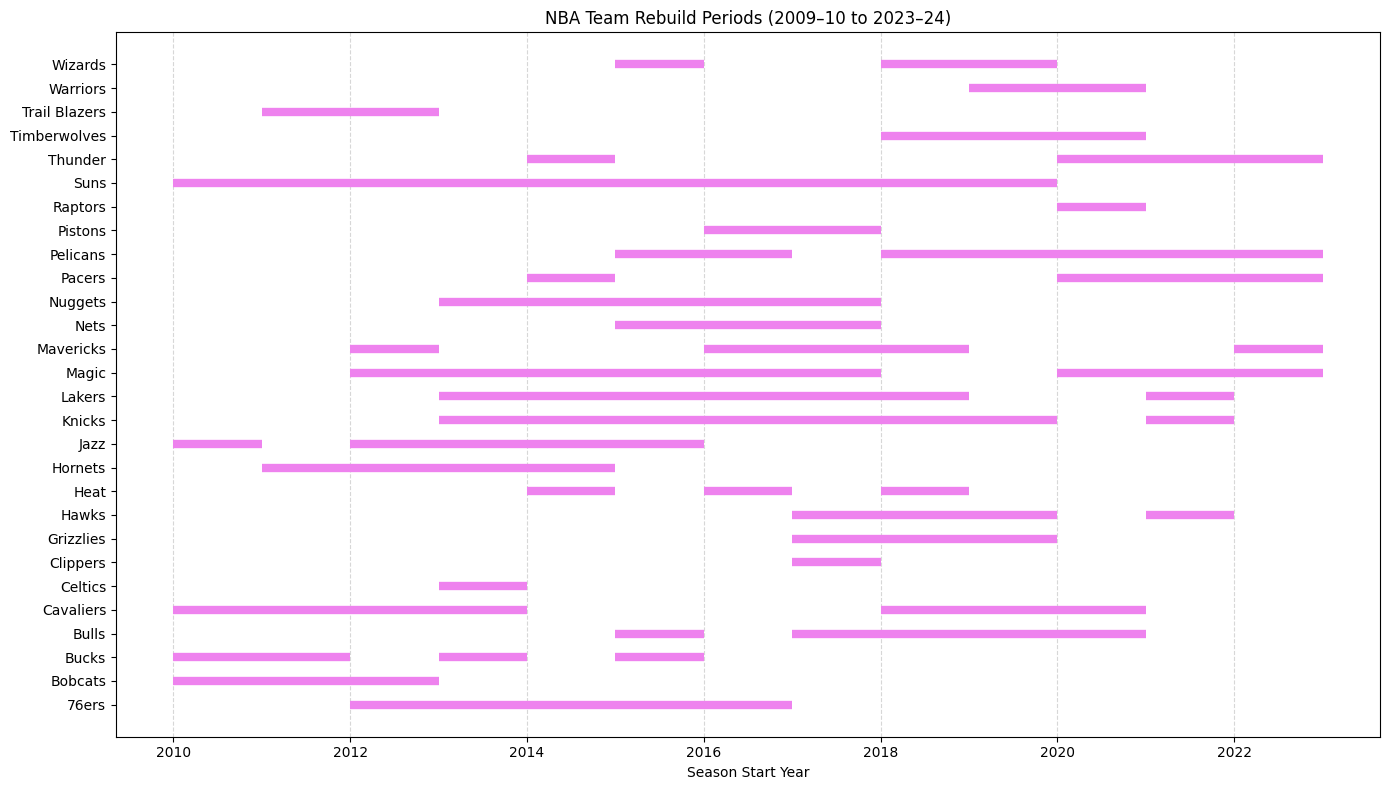

In [55]:
import matplotlib.pyplot as plt

# Ensure rebuilds_df exists
if 'rebuilds_df' not in locals():
    rebuilds_df = compute_rebuilds(all_standings)

# Sort teams alphabetically for consistent plotting
teams = sorted(rebuilds_df['Team'].unique())
team_to_y = {team: i for i, team in enumerate(teams)}

plt.figure(figsize=(14, 8))

for _, row in rebuilds_df.iterrows():
    y = team_to_y[row['Team']]
    start_year = int(row['Start'].split('-')[0])
    end_year = int(row['End'].split('-')[0])
    plt.hlines(y=y, xmin=start_year, xmax=end_year, color='violet', linewidth=6)

plt.yticks(range(len(teams)), teams)
plt.xlabel("Season Start Year")
plt.title("NBA Team Rebuild Periods (2009–10 to 2023–24)")
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()
